#### Імпорт необхідних бібліотек (або окремих компонентів)

In [1]:
import json
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone
from sklearn.metrics import r2_score

#### Функція для отримання даних з _CryptoCompare API_ про коливання курсу BTC/USD за вказний період з подальшим збереженням у форматі JSON

In [2]:
def fetch_btc_historical_data(symbol: str, end_date: str, limit: int = 364, currency: str = "USD") -> str:
    start_date = (datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=limit + 1)).strftime("%Y-%m-%d")
    end_timestamp = int(datetime.strptime(end_date, "%Y-%m-%d").timestamp())
    
    url = "https://min-api.cryptocompare.com/data/v2/histoday"
    
    headers = {
        "Accepts": "application/json",
    }
    
    params = {
        "fsym": symbol,
        "tsym": currency,
        "limit": limit,
        "toTs": end_timestamp
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        data = response.json()

        # Extract only the "Data" array and convert unix timestamp to date format
        extracted_data = []
        for entry in data["Data"]["Data"]:
            entry["date"] = datetime.fromtimestamp(entry["time"], tz=timezone.utc).strftime("%Y-%m-%d")
            del entry["time"]
            extracted_data.append(entry)

        file_name = f"{symbol}-{currency}_{start_date}_{end_date}.json"

        with open(file_name, "w") as file:
            json.dump(extracted_data, file, indent=4)

        print(f"Data saved successfully: \"{file_name}\"")
        return file_name
    else:
        raise Exception(f"Error {response.status_code}: {response.text}")

json_data = fetch_btc_historical_data("BTC", "2023-01-01")

Data saved successfully: "BTC-USD_2022-01-01_2023-01-01.json"


#### Формат вхідних даних (збережений JSON документ)

In [3]:
!head -n 23 *.json

[
    {
        "high": 47950.29,
        "low": 46196.03,
        "open": 46197.31,
        "volumefrom": 16697.92,
        "volumeto": 786729972.03,
        "close": 47737.35,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2022-01-01"
    },
    {
        "high": 47979.26,
        "low": 46666.18,
        "open": 47737.35,
        "volumefrom": 13025.66,
        "volumeto": 615453426.93,
        "close": 47306.41,
        "conversionType": "direct",
        "conversionSymbol": "",
        "date": "2022-01-02"
    },


#### Створення pandas DataFrame на основі збереженого JSON документу та вивід загальної інформації

In [4]:
cols = ["date", "open", "close", "high", "low"]

df = pd.read_json(json_data)[cols]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2022-01-01 to 2022-12-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    365 non-null    float64
 1   close   365 non-null    float64
 2   high    365 non-null    float64
 3   low     365 non-null    float64
dtypes: float64(4)
memory usage: 14.3 KB


#### Вивід статистичних характеристик отриманих даних
- *count* - кількість спостережень (значень) у кожному стовпці
- *mean* - середнє арифметичне
- *std* - стандартне відхилення
- *min* та *max* - найменше та найбільше значення у вибірці
- *25%*, *50%*, *75%* - перший, другий (медіана) і третій квартилі

In [5]:
df.describe()

,open,close,high,low
count,365.000000,365.000000,365.000000,365.000000
mean,28267.278055,28186.001342,28875.363918,27540.394658
std,10222.664236,10197.618537,10461.473755,9949.503481
min,15760.190000,15760.190000,16272.470000,15480.690000
25%,19550.490000,19541.280000,20052.130000,19159.470000
50%,23179.860000,23156.660000,23595.740000,22668.870000
75%,39154.400000,39134.830000,39922.600000,38043.510000
max,47737.350000,47737.350000,48208.480000,47018.870000


#### Графік зміни курсу BTC/USD (денна ціна закриття) за 2022 рік

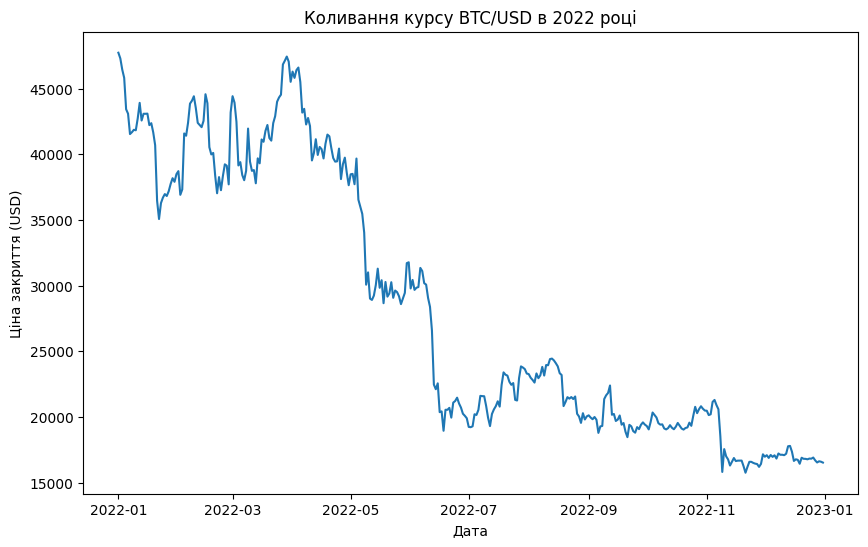

In [6]:
plt.figure(figsize=(10,6))
plt.plot(df["close"])
plt.title("Коливання курсу BTC/USD в 2022 році")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.show()

#### Побудова поліноміальної регресійної моделі з ступінем полінома - 3

In [7]:
def fit_polynomial(y: np.ndarray, degree: int) -> np.poly1d:
    x = np.arange(len(y))
    coeffs = np.polyfit(x, y, deg=degree)
    print(f"Коефіцієнти полінома ступіня {degree}: {coeffs}")
    return np.poly1d(coeffs)

degree = 3
y = df["close"].values

polynomial = fit_polynomial(y, degree)
trend = polynomial(np.arange(len(y)))

Коефіцієнти полінома ступіня 3: [ 1.91321173e-03 -9.00183428e-01  1.09207985e+01  4.28787011e+04]


#### Візуалізація реальних даних та тренду

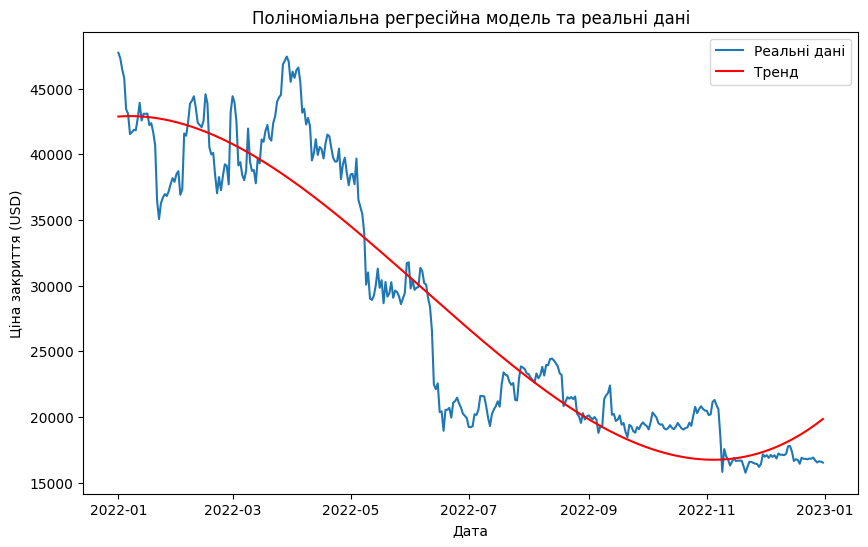

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df.index, y, label="Реальні дані")
plt.plot(df.index, trend, label="Тренд", color='red')
plt.title("Поліноміальна регресійна модель та реальні дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Обчислення коефіцієнту детермінації R²

In [9]:
r2 = r2_score(y, trend)
print(f"Коефіцієнт детермінації R²: {r2:.4f}")

Коефіцієнт детермінації R²: 0.8861


#### Аналіз відхилень (шуму) від тренду

In [10]:
def stats(data: np.ndarray, label: str) -> tuple[float, float, float]:
    mean, std, variance = data.mean(), data.std(), data.var()
    print(f"{label}:\nMean: {mean}\nStandard deviation: {std:.4f}\nVariance: {variance:.4f}")
    return mean, std, variance

deviation = df["close"] - trend
mean_deviation, std_deviation, _ = stats(deviation, "Статистичні показники відхилинь від тренду")

Статистичні показники відхилинь від тренду:
Mean: 2.5416016323517448e-11
Standard deviation: 3441.8261
Variance: 11846166.5945


#### Побудова гістограми відхилень для візуального аналізу розподілу

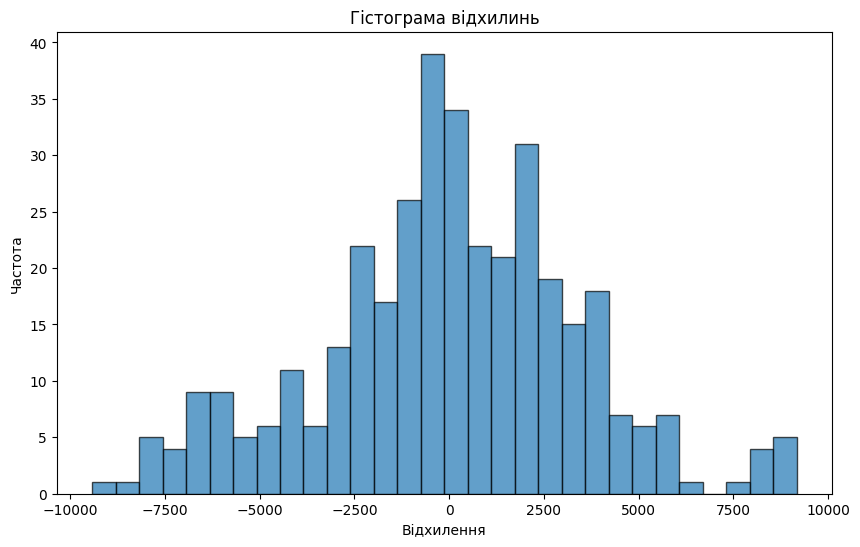

In [11]:
plt.figure(figsize=(10,6))
plt.hist(deviation, bins=30, edgecolor='k', alpha=0.7)
plt.title("Гістограма відхилинь")
plt.xlabel("Відхилення")
plt.ylabel("Частота")
plt.show()

#### Генерація випадкового шуму та отримання синтезованих даних

In [12]:
np.random.seed(12) # Статичне значення seed для відтворюваності результатів
noise = np.random.normal(mean_deviation, std_deviation, size=deviation.size)

synthetic_data = trend + noise

#### Побудова гістограми згенерованого шуму

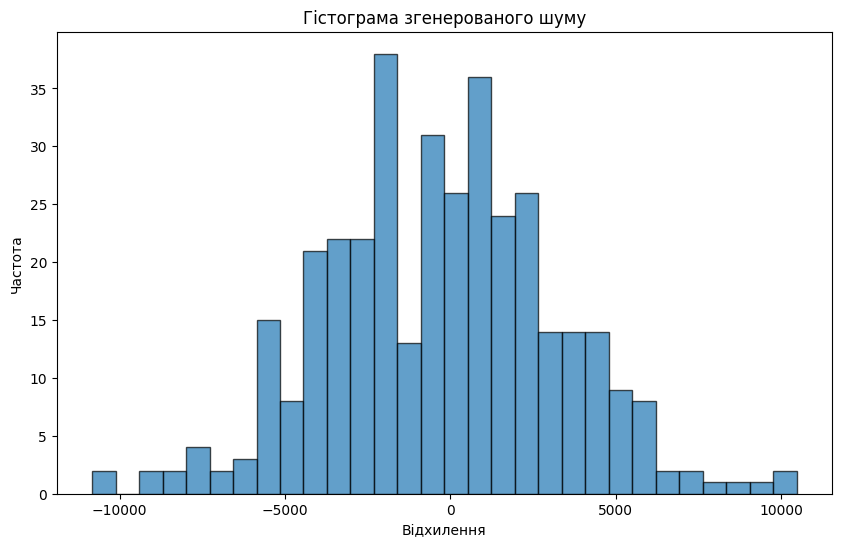

In [13]:
plt.figure(figsize=(10,6))
plt.hist(noise, bins=30, edgecolor='k', alpha=0.7)
plt.title("Гістограма згенерованого шуму")
plt.xlabel("Відхилення")
plt.ylabel("Частота")
plt.show()

#### Статистичні показники синтезованих даних

In [14]:
_ = stats(synthetic_data, "Статистичні показники синтезованих даних")

Статистичні показники синтезованих даних:
Mean: 27893.299959418862
Standard deviation: 9969.3365
Variance: 99387669.8512


#### Графік порівняння реальних та синтезованих даних

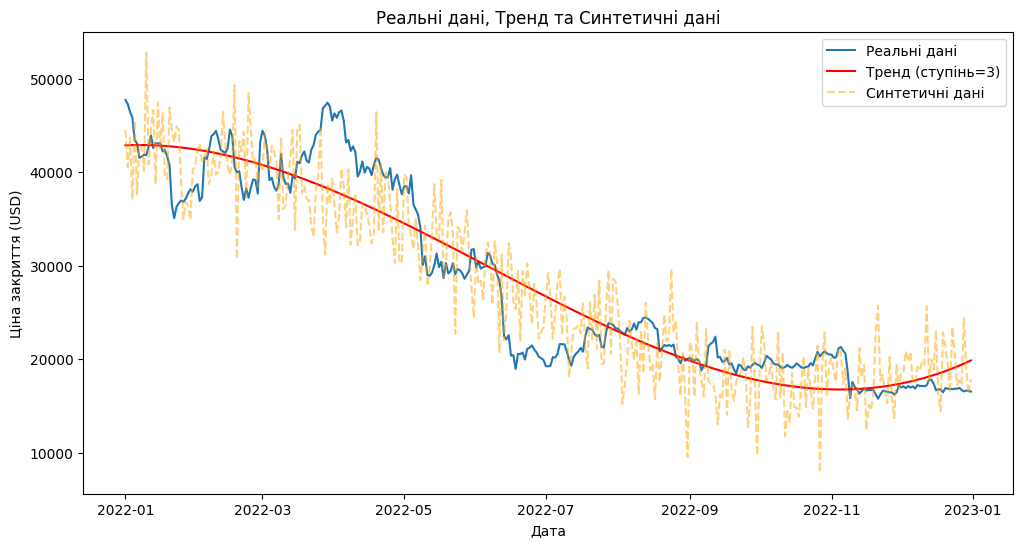

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, y, label="Реальні дані")
plt.plot(df.index, trend, label=f"Тренд (ступінь={degree})", color='red')
plt.plot(df.index, synthetic_data, label="Синтетичні дані", color='orange', alpha=0.5, linestyle='--')
plt.title("Реальні дані, Тренд та Синтетичні дані")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття (USD)")
plt.legend()
plt.show()

#### Порівняння статистичних показників реальних та синтезованих даних

In [16]:
def compare_statistics(real_data: np.ndarray, synthetic_data: np.ndarray) -> None:
    real_mean, real_std, real_variance = real_data.mean(), real_data.std(), real_data.var()
    synth_mean, synth_std, synth_variance = synthetic_data.mean(), synthetic_data.std(), synthetic_data.var()

    mean_deviation = abs(real_mean - synth_mean)
    std_deviation = abs(real_std - synth_std)
    variance_deviation = abs(real_variance - synth_variance)

    print("Metric         | Real Data         | Synthetic Data  | Deviation")
    print("-----------------------------------------------------------------")
    print(f"Mean           | {real_mean:<17.6f} | {synth_mean:<17.6f} | {mean_deviation:<10.6f}")
    print(f"Std Dev        | {real_std:<17.6f} | {synth_std:<17.6f} | {std_deviation:<10.6f}")
    print(f"Variance       | {real_variance:<17.6f} | {synth_variance:<17.6f} | {variance_deviation:<10.6f}")

compare_statistics(y, synthetic_data)

Metric         | Real Data         | Synthetic Data  | Deviation
-----------------------------------------------------------------
Mean           | 28186.001342      | 27893.299959      | 292.701383
Std Dev        | 10183.639615      | 9969.336480       | 214.303135
Variance       | 103706515.814842  | 99387669.851183   | 4318845.963659
